In [102]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
#!pip install japanize-matplotlib
import japanize_matplotlib
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from scipy.cluster.hierarchy import dendrogram
from sklearn.cluster import AgglomerativeClustering
import plotly.express as px

読み込みと特徴量

In [74]:
date_col = 'RequestStartTime_date'
sc_col = 'HTTPStatusCode'
ip_col = 'SourceIP'
hour_col = 'RequestStartTime_hour'
uri_col = 'RequestURI'
badcode_col = 'Bad_code'
baduri_col = 'contain_bad_uri'

bad_code = [
    400,  # Bad Request
    401,  # Unauthorized
    403,  # Forbidden
    404,  # Not Found
    405,  # Method Not Allowed
    414,  # URI Too Long
    429,  # Too Many Requests
    500,  # Internal Server Error
    502,  # Bad Gateway
    503,  # Service Unavailable
    504   # Gateway Timeout
]

bad_uri = ['delete']

In [75]:
df = pd.read_csv('/content/drive/MyDrive/dataset/api_log/API_logs_with_request_verb.csv')
df['RequestStartTime'] = pd.to_datetime(df['RequestStartTime'])
df['RequestStartTime_date'] = df['RequestStartTime'].dt.date
df['RequestStartTime_hour'] = df['RequestStartTime'].dt.hour
df['Bad_code'] = df['HTTPStatusCode'].apply(lambda x: 1 if x in bad_code else 0)
df['last_uri'] = df['RequestURI'].apply(lambda x:x.split('/')[-1])
df['contain_bad_uri'] =  df['last_uri'].apply(lambda x: 1 if x in bad_uri else 0)
df.head()

,SourceIP,RequestURI,HTTPStatusCode,RequestStartTime,RequestEndTime,UserAgent,RequestAPI,RequestVerb,IsSuspicious,RequestStartTime_date,RequestStartTime_hour,Bad_code,last_uri,contain_bad_uri
0,192.168.188.142,/api/v1/delete,429,2024-01-19 00:26:58,2024-01-19 00:31:19,curl/7.68.0,DeleteAPI,DELETE,False,2024-01-19,0,1,delete,1
1,192.168.53.151,/api/v1/delete,429,2024-01-24 12:49:04,2024-01-24 12:52:57,Mozilla/5.0 (Windows NT 10.0; Win64; x64),DeleteAPI,OPTIONS,False,2024-01-24,12,1,delete,1
2,192.168.155.133,/api/v1/delete,403,2024-01-05 10:54:32,2024-01-05 10:57:25,Googlebot/2.1 (+http://www.google.com/bot.html),UpdateAPI,POST,False,2024-01-05,10,1,delete,1
3,192.168.104.127,/api/v1/resource,404,2024-01-10 18:44:42,2024-01-10 18:48:37,PostmanRuntime/7.29.2,ResourceAPI,PATCH,False,2024-01-10,18,1,resource,0
4,192.168.219.219,/api/v1/delete,403,2024-01-18 10:12:34,2024-01-18 10:17:03,PostmanRuntime/7.29.2,UpdateAPI,PATCH,False,2024-01-18,10,1,delete,1


In [68]:
df['last_uri'].value_counts()
# fig, ax = plt.subplots()
# sns.barplot()

,count
last_uri,
delete,33546
update,33397
resource,33057


In [5]:
df.groupby([date_col, sc_col]).size().reset_index(name='RequestCount')

,RequestStartTime_date,HTTPStatusCode,RequestCount
0,2024-01-01,200,380
1,2024-01-01,201,375
2,2024-01-01,400,395
3,2024-01-01,401,430
4,2024-01-01,403,434
...,...,...,...
243,2024-01-31,401,398
244,2024-01-31,403,434
245,2024-01-31,404,415
246,2024-01-31,429,396


変なURIを含むか

In [66]:
df.query('contain_bad_uri==1')

,SourceIP,RequestURI,HTTPStatusCode,RequestStartTime,RequestEndTime,UserAgent,RequestAPI,RequestVerb,IsSuspicious,RequestStartTime_date,RequestStartTime_hour,Bad_code,contain_bad_uri


DDoS攻撃、複数のIPアドレスから短時間に多数のリクエストが集中する

,SourceIP
RequestStartTime_date,
2024-01-26,3339
2024-01-14,3332
2024-01-18,3299
2024-01-15,3290
2024-01-25,3275


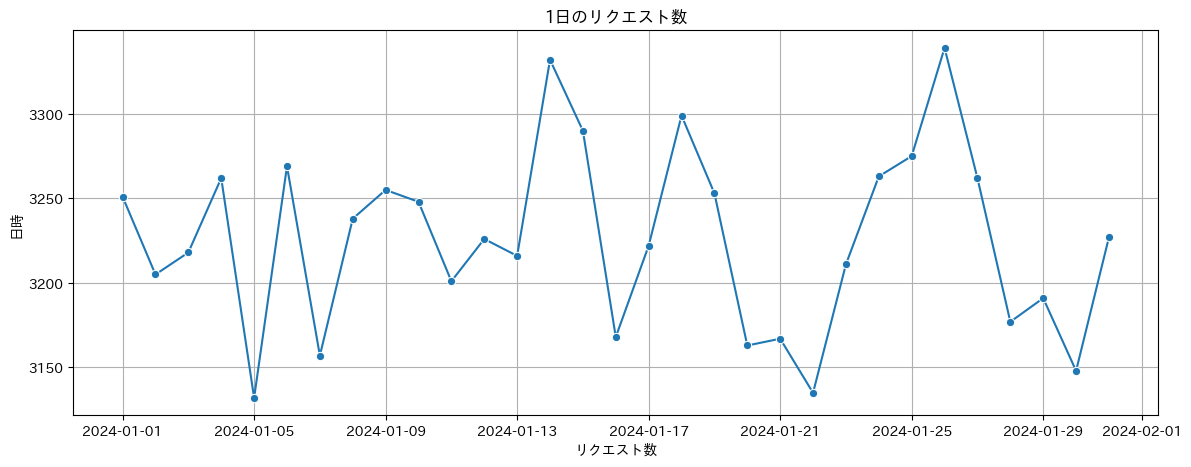

In [40]:
data = df.groupby([date_col])[ip_col].size()
display(data.sort_values(ascending=False).head(5))

fig, ax = plt.subplots(figsize=(14, 5))
sns.lineplot(x=data.index, y=data, marker='o')
plt.title('1日のリクエスト数');plt.xlabel('日時');plt.ylabel('リクエスト数')
plt.grid();plt.show()

In [44]:
data = df.groupby([date_col, hour_col])[ip_col].nunique()
display(data.sort_values(ascending=False).head(5))

,,SourceIP
RequestStartTime_date,RequestStartTime_hour,
2024-01-18,3,168
2024-01-14,4,167
2024-01-24,0,165
2024-01-29,20,164
2024-01-11,17,164


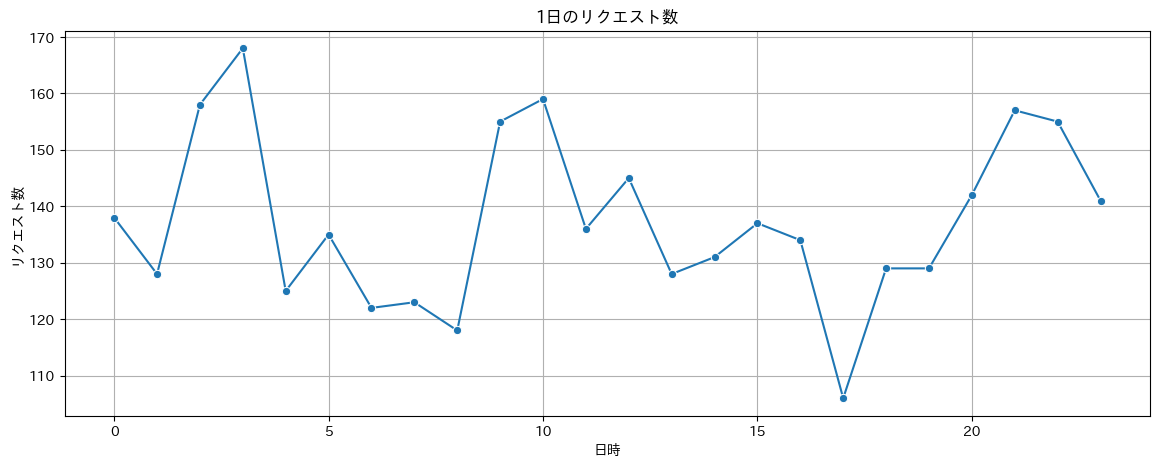

In [45]:
dt = pd.to_datetime('2024-01-18').date()
data = df.query("RequestStartTime_date==@dt").groupby([hour_col])[ip_col].nunique()

fig, ax = plt.subplots(figsize=(14, 5))
sns.lineplot(x=data.index, y=data, marker='o')
plt.title('1日のリクエスト数');plt.xlabel('日時');plt.ylabel('リクエスト数')
plt.grid();plt.show()

レートリミット、短時間に異なるIPから同じリクエストURIが大量に送信される。429

In [53]:
df.groupby([date_col, ip_col, uri_col])[uri_col].size().sort_values(ascending=False)

RequestStartTime_date  SourceIP         RequestURI      
2024-01-18             192.168.8.162    /api/v1/resource    3
2024-01-06             192.168.153.7    /api/v1/resource    3
2024-01-21             192.168.230.184  /api/v1/update      3
2024-01-27             192.168.138.90   /api/v1/delete      3
2024-01-29             192.168.177.87   /api/v1/resource    3
                                                           ..
2024-01-11             192.168.187.190  /api/v1/resource    1
                       192.168.187.166  /api/v1/delete      1
                       192.168.187.139  /api/v1/delete      1
                       192.168.187.119  /api/v1/update      1
2024-01-31             192.168.99.75    /api/v1/update      1
Name: RequestURI, Length: 99197, dtype: int64

ブルートフォース攻撃、特定のURIやステータスコード（401 Unauthorized や 403 Forbidden）が多発する

,Bad_code
RequestStartTime_date,
2024-01-26,2576
2024-01-15,2544
2024-01-04,2527
2024-01-14,2524
2024-01-06,2524


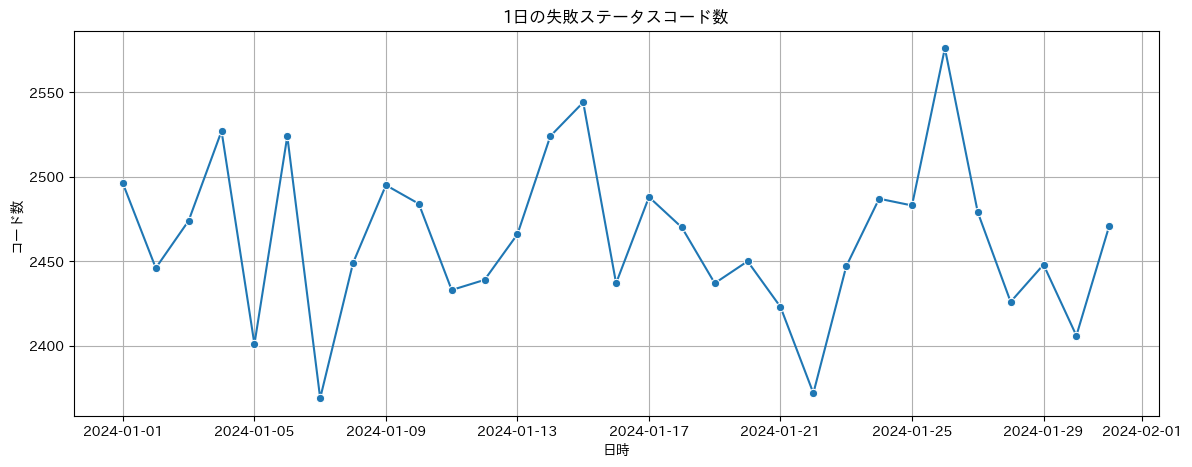

In [71]:
data = df.groupby([date_col])[badcode_col].sum()
display(data.sort_values(ascending=False).head())
fig, ax = plt.subplots(figsize=(14, 5))
sns.lineplot(x=data.index, y=data, marker='o')
plt.title('1日の失敗ステータスコード数');plt.xlabel('日時');plt.ylabel('コード数')
plt.grid();plt.show()

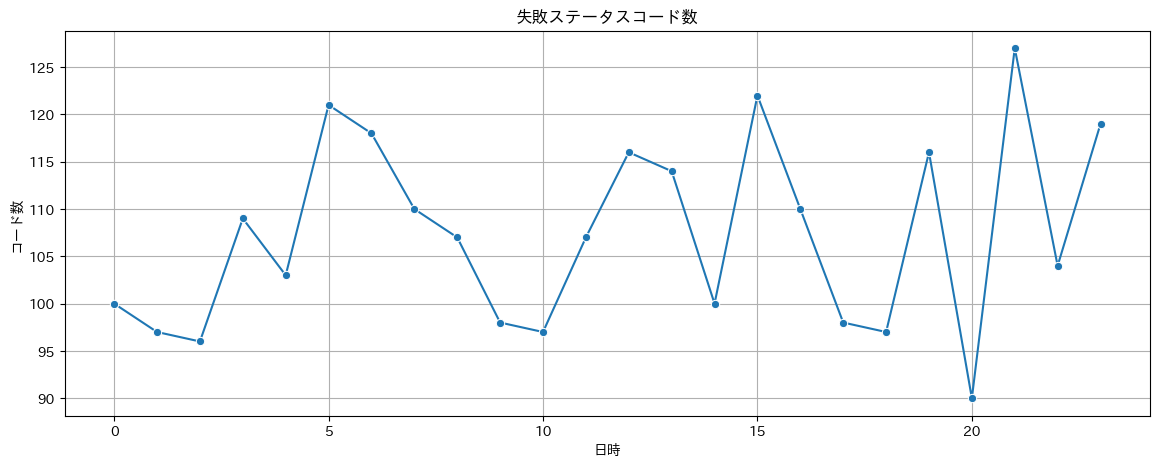

In [77]:
dt = pd.to_datetime('2024-01-26').date()
data = df.query("RequestStartTime_date==@dt").groupby([hour_col])[badcode_col].sum()

fig, ax = plt.subplots(figsize=(14, 5))
sns.lineplot(x=data.index, y=data, marker='o')
plt.title('失敗ステータスコード数');plt.xlabel('日時');plt.ylabel('コード数')
plt.grid();plt.show()

In [79]:
df[sc_col].nunique()

8

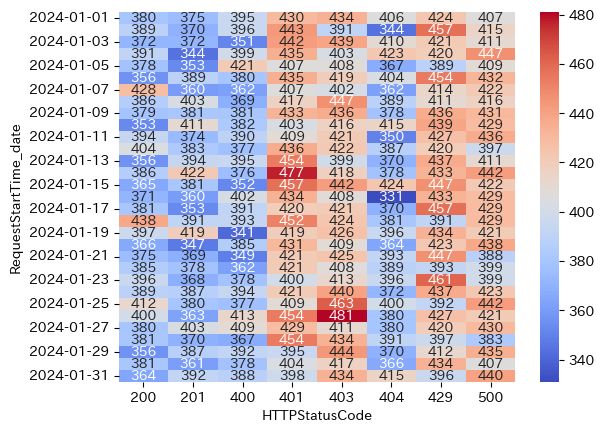

In [101]:
# data = df.groupby([date_col, sc_col]).size().reset_index(name='HTTPStatusCode_count')
data = pd.pivot_table(df, index=date_col, columns=sc_col, aggfunc='size')
data_rate = data.div(data.sum(axis=1), axis=0)

# ヒートマップで基礎可視化
fig, ax = plt.subplots()
sns.heatmap(data, fmt='.0f', annot=True, cmap='coolwarm')
plt.show()
# fig, ax = plt.subplots()
# sns.heatmap(data_rate, fmt='.2f', annot=True, cmap='coolwarm')
# plt.show()

# PCAでわかりやすく2次元配置
ss = StandardScaler()
pca = PCA()
data_pca = pd.DataFrame(pca.fit_transform(ss.fit_transform(data))[:, :2], columns=['x', 'y'])
data_pca['date'] = data.index.tolist()
fig = px.scatter(data_pca, x='x', y='y', hover_data=['date'])
fig.show()

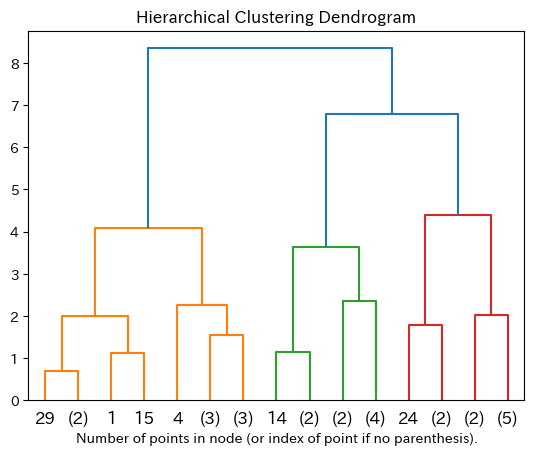

In [106]:
def plot_dendrogram(model, **kwargs):
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack(
        [model.children_, model.distances_, counts]
    ).astype(float)
    dendrogram(linkage_matrix, **kwargs)

X = data_pca[['x', 'y']]
# setting distance_threshold=0 ensures we compute the full tree.
model = AgglomerativeClustering(distance_threshold=0, n_clusters=None)
model = model.fit(X)
plt.title("Hierarchical Clustering Dendrogram")
plot_dendrogram(model, truncate_mode="level", p=3)
plt.xlabel("Number of points in node (or index of point if no parenthesis).")
plt.show()